# OCR lora finetuning and merging using Transformers + Peft + TRL

## import libs

In [1]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig,Qwen2VLProcessor
from peft import LoraConfig
from qwen_vl_utils import process_vision_info
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import glob
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
import random

# Dataset Preparation

In [2]:
from datasets import load_dataset

dataset = load_dataset("lbourdois/OCR-liboaccn-OPUS-MIT-5M-clean", 'en', split="train")
# To select the first 2000 examples
train_dataset = dataset.select(range(2000))

# To select the next 200 examples for evaluation
eval_dataset = dataset.select(range(2000, 2200))

# Convert dataset to OAI messages       
def format_data(sample):
    return {"messages": [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system_message}],
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": sample["question"],
                        },{
                            "type": "image",
                            "image": sample["image"],
                        }
                    ],
                },
                {
                    "role": "assistant",
                    "content": [{"type": "text", "text": sample["answer"]}],
                },
            ],
        }

system_message = "You are an expert french ocr system."
# Convert dataset to OAI messages
# need to use list comprehension to keep Pil.Image type, .mape convert image to bytes
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/50 [00:00<?, ?it/s]

# Setup OCR main evaluation and help functions

In [3]:
import os
import torch
from tqdm import tqdm
import pandas as pd
from jiwer import wer, cer
from qwen_vl_utils import process_vision_info

def evaluate_ocr_model(model, processor, dataset, output_dir="ocr_evaluation_results"):
    """
    Evaluate a Qwen VL model on an OCR dataset with specific structure.
    
    Args:
        model: The loaded Qwen VL model
        processor: The Qwen processor/tokenizer
        dataset: List of items with 'messages' field containing conversation exchanges
        output_dir: Directory to save results
    
    Returns:
        tuple: (average WER, average CER)
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize results storage
    results = []
    
    # Process each sample in the dataset
    for i, sample in enumerate(tqdm(dataset, desc="Evaluating OCR performance")):
        try:
            # Extract the messages from the sample
            messages = sample['messages']
            
            # Extract system message (if present)
            system_message = next((msg for msg in messages if msg['role'] == 'system'), None)
            
            # Extract user message with the image and question
            user_message = next((msg for msg in messages if msg['role'] == 'user'), None)
            if not user_message:
                print(f"Skipping sample {i}: No user message found")
                continue
                
            # Extract assistant message with ground truth
            assistant_message = next((msg for msg in messages if msg['role'] == 'assistant'), None)
            if not assistant_message:
                print(f"Skipping sample {i}: No assistant message (ground truth) found")
                continue
            
            # Extract ground truth text
            ground_truth = None
            for content_item in assistant_message['content']:
                if content_item['type'] == 'text':
                    ground_truth = content_item['text']
                    break
                    
            if not ground_truth:
                print(f"Skipping sample {i}: No text found in assistant message")
                continue
            
            # Extract image and question from user message
            image = None
            question = None
            
            for content_item in user_message['content']:
                if content_item['type'] == 'image':
                    image = content_item['image']
                elif content_item['type'] == 'text':
                    question = content_item['text']
            
            if not image:
                print(f"Skipping sample {i}: No image found in user message")
                continue
                
            if not question:
                print(f"Skipping sample {i}: No question found in user message")
                continue
            
            # Construct messages for the model input (excluding assistant message)
            input_messages = []
            
            # Add system message if it exists
            if system_message:
                input_messages.append(system_message)
            
            # Add user message
            input_messages.append(user_message)
            
            # Preparation for inference using Qwen's specific processing
            text = processor.apply_chat_template(
                input_messages, tokenize=False, add_generation_prompt=True
            )
            
            # Process vision info (images/videos) from messages
            image_inputs, video_inputs = process_vision_info(input_messages)
            
            # Create model inputs
            inputs = processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt"
            )
            inputs = inputs.to(model.device)
            
            # Generate response
            with torch.no_grad():
                generated_ids = model.generate(
                    **inputs, 
                    max_new_tokens=1024,
                    temperature=1.5, 
                    min_p=0.1,
                    use_cache=True
                )
            
            # Extract only the generated part (not the input)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            
            # Decode the generated text
            generated_response = processor.batch_decode(
                generated_ids_trimmed, 
                skip_special_tokens=True, 
                clean_up_tokenization_spaces=False
            )[0]
            
            # Calculate metrics
            word_error = wer(ground_truth, generated_response)
            char_error = cer(ground_truth, generated_response)
            
            # Save individual result
            output_file = os.path.join(output_dir, f"sample_{i}.txt")
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(f"Sample {i}\n")
                f.write(f"Question: {question}\n\n")
                f.write(f"Model output:\n{generated_response.strip()}\n\n")
                f.write(f"Ground truth:\n{ground_truth}\n\n")
                f.write(f"WER: {word_error:.4f}, CER: {char_error:.4f}")
            
            # Store results for summary
            results.append({
                'sample_id': i,
                'wer': word_error,
                'cer': char_error,
                'model_output': generated_response.strip(),
                'ground_truth': ground_truth,
                'question': question
            })
            
        except Exception as e:
            print(f"Error processing sample {i}: {str(e)}")
            import traceback
            traceback.print_exc()
            
    # Create summary report
    if results:
        df = pd.DataFrame(results)
        
        # Calculate overall averages
        avg_wer = df['wer'].mean()
        avg_cer = df['cer'].mean()
        
        # Save average metrics
        with open(os.path.join(output_dir, "avg_metrics.txt"), 'w') as f:
            f.write(f"Average WER: {avg_wer:.4f}\n")
            f.write(f"Average CER: {avg_cer:.4f}\n")
        
        # Save detailed results
        df.to_csv(os.path.join(output_dir, "detailed_results.csv"), index=False)
        
        print("\nResults Summary:")
        print(f"Average WER: {avg_wer:.4f}")
        print(f"Average CER: {avg_cer:.4f}")
        print(f"\nDetailed results saved to {output_dir}/")
        
        return avg_wer, avg_cer
    else:
        print("No results to summarize.")
        return None, None


# At the beginning of your notebook, define a variable to collect results
model_comparison_results = {}

# Create a simple function to add results to the comparison
def add_to_comparison(model_name, wer, cer):
    """Add model results to the comparison tracker"""
    model_comparison_results[model_name] = {
        "wer": wer,
        "cer": cer
    }
    #return model_comparison_results

# Create a function to print the comparison report whenever needed
def print_model_comparison(save_csv=True, save_plot=True):
    """Print a comparison of all models evaluated so far"""
    if not model_comparison_results:
        print("No model results available for comparison")
        return
        
    print("\n==== MODEL COMPARISON REPORT ====")
    
    # Create a comparison dataframe
    comparison_df = pd.DataFrame({
        "Model": list(model_comparison_results.keys()),
        "WER": [results["wer"] for results in model_comparison_results.values()],
        "CER": [results["cer"] for results in model_comparison_results.values()]
    })
    
    # Sort by WER (best performance first)
    comparison_df = comparison_df.sort_values("WER")
    
    # Display the comparison table
    print("\nComparison Table (sorted by WER):")
    print(comparison_df.to_string(index=False))
    
    # Save the comparison table
    if save_csv:
        comparison_file = "model_comparison_results.csv"
        comparison_df.to_csv(comparison_file, index=False)
        print(f"\nComparison table saved to {comparison_file}")
    
    # Generate a bar chart visualization
    if save_plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        
        # Plot WER
        plt.subplot(1, 2, 1)
        plt.bar(comparison_df["Model"], comparison_df["WER"], color='skyblue')
        plt.title('Word Error Rate Comparison')
        plt.ylabel('WER (lower is better)')
        plt.ylim(bottom=0)
        plt.xticks(rotation=45, ha='right')
        
        # Plot CER
        plt.subplot(1, 2, 2)
        plt.bar(comparison_df["Model"], comparison_df["CER"], color='lightgreen')
        plt.title('Character Error Rate Comparison')
        plt.ylabel('CER (lower is better)')
        plt.ylim(bottom=0)
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('ocr_model_comparison.png')
        plt.show()
        
        print(f"\nVisualization saved to ocr_model_comparison.png")
    
    return comparison_df

# Finetuning setup and run

## Load base model

In [4]:
# Hugging Face model id
model_id = "unsloth/Qwen2-VL-7B-Instruct" 

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    # attn_implementation="flash_attention_2", # not supported for training
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
# benchmark base model performance
model_name = "Base model" 
avg_wer, avg_cer = evaluate_ocr_model(model, processor, eval_dataset, output_dir="peft_base_model_results")
add_to_comparison(model_name, avg_wer, avg_cer)

Evaluating OCR performance: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [10:06<00:00,  3.03s/it]


Results Summary:
Average WER: 3.6077
Average CER: 2.7190

Detailed results saved to peft_base_model_results/


## Lora Finetuning

In [6]:
from peft import LoraConfig

# LoRA config based on QLoRA paper & Sebastian Raschka experiment
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.05,
        r=8,
        bias="none",
        target_modules=["q_proj", "v_proj"],
        task_type="CAUSAL_LM", 
)

In [7]:
from trl import SFTConfig
from transformers import Qwen2VLProcessor
from qwen_vl_utils import process_vision_info

args = SFTConfig(
    output_dir="peft-qwen2-7vl-french-ocr-checkpoints", # directory to save and repository id
    num_train_epochs=2,                     # number of training epochs
    #max_steps = 60,
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_accumulation_steps=8,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=5,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    report_to="none",                # report metrics to tensorboard
    gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True} # important for collator
)
args.remove_unused_columns=False

# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example["messages"], tokenize=False) for example in examples]
    image_inputs = [process_vision_info(example["messages"])[0] for example in examples]

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  #
    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):
        image_tokens = [151652,151653,151655]
    else: 
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100
    batch["labels"] = labels

    return batch

In [8]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    data_collator=collate_fn,
    #dataset_text_field="", # needs dummy value
    peft_config=peft_config,
    processing_class=processor,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [9]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

# save model 
trainer.save_model("peft-qwen2-7vl-french-ocr-adapter")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
5,3.416800
10,2.926000
15,2.373200
20,1.943900
25,1.659600
30,1.636300
35,1.498500
40,1.376600
45,1.463900
50,1.384300


# Load adapter model and measure adapter performance

In [10]:
# Load Base_Model


model_id = "Qwen/Qwen2-VL-7B-Instruct" 
# Load Model base model
model = AutoModelForVision2Seq.from_pretrained(
  model_id,
  device_map="auto",
  torch_dtype=torch.bfloat16
)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
# Load adapter on top of base model
adapter_path = "./peft-qwen2-7vl-french-ocr-adapter"
model.load_adapter(adapter_path)

In [12]:
# benchmark lora model performance
model_name = "Peft lora model" 
avg_wer, avg_cer = evaluate_ocr_model(model, processor, eval_dataset, output_dir="peft_lora_model_results")
add_to_comparison(model_name, avg_wer, avg_cer)

Evaluating OCR performance: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:38<00:00,  1.26it/s]


Results Summary:
Average WER: 0.0386
Average CER: 0.0160

Detailed results saved to peft_lora_model_results/


# Merge Model

In [13]:
from peft import PeftModel
from transformers import AutoProcessor, AutoModelForVision2Seq

adapter_path = "./peft-qwen2-7vl-french-ocr-adapter"
base_model_id = "unsloth/Qwen2-VL-7B-Instruct"
merged_path = "peft_merged_model_french_ocr_qwen7-vl"

# Load Model base model
model = AutoModelForVision2Seq.from_pretrained(model_id, low_cpu_mem_usage=True)

# Path to save the merged model

# Merge LoRA and base model and save
peft_model = PeftModel.from_pretrained(model, adapter_path)
merged_model = peft_model.merge_and_unload()
merged_model.save_pretrained(merged_path,safe_serialization=True, max_shard_size="2GB")

processor = AutoProcessor.from_pretrained(base_model_id)
processor.save_pretrained(merged_path)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

[]

# Benchmark merged model performance

## load merged model in 4 bits

In [14]:
# model = AutoModelForVision2Seq.from_pretrained(
#   "./merged_model_french_ocr_qwen7-vl",
#   torch_dtype=torch.bfloat16
# )
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig,Qwen2VLProcessor
from peft import LoraConfig
from qwen_vl_utils import process_vision_info
merged_path = "peft_merged_model_french_ocr_qwen7-vl"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
merged_model = AutoModelForVision2Seq.from_pretrained(
    merged_path,
    device_map="auto",
    # attn_implementation="flash_attention_2", # not supported for training
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
merged_processor = AutoProcessor.from_pretrained(merged_path)

Loading checkpoint shards:   0%|          | 0/18 [00:00<?, ?it/s]

In [15]:
# benchmark 4bits lora model performance
model_name = "Merged model 4bits" 
avg_wer, avg_cer = evaluate_ocr_model(merged_model, merged_processor, eval_dataset, output_dir="peft_merged_model_4bit_ocr_results")
add_to_comparison(model_name, avg_wer, avg_cer)

Evaluating OCR performance: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:33<00:00,  1.07s/it]


Results Summary:
Average WER: 1.8805
Average CER: 1.3268

Detailed results saved to peft_merged_model_4bit_ocr_results/


## load merged model in 8 bits

In [16]:
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig,Qwen2VLProcessor
from peft import LoraConfig
from qwen_vl_utils import process_vision_info


quantization_config = BitsAndBytesConfig(load_in_8bit=True)

merged_model = AutoModelForVision2Seq.from_pretrained(
    merged_path,
    device_map="auto",
    quantization_config=quantization_config
)

merged_processor = AutoProcessor.from_pretrained(merged_path)

Loading checkpoint shards:   0%|          | 0/18 [00:00<?, ?it/s]

In [17]:
# benchmark 8 bits lora model performance
model_name = "Merged model 8bits" 
avg_wer, avg_cer = evaluate_ocr_model(merged_model, merged_processor, eval_dataset, output_dir="peft_merged_model_4bit_ocr_results")
add_to_comparison(model_name, avg_wer, avg_cer)

Evaluating OCR performance: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [06:53<00:00,  2.07s/it]


Results Summary:
Average WER: 0.0381
Average CER: 0.0136

Detailed results saved to peft_merged_model_4bit_ocr_results/


# Model performance comparison report


==== MODEL COMPARISON REPORT ====

Comparison Table (sorted by WER):
             Model      WER      CER
Merged model 8bits 0.038061 0.013620
   Peft lora model 0.038568 0.015985
Merged model 4bits 1.880497 1.326828
        Base model 3.607724 2.718979

Comparison table saved to model_comparison_results.csv


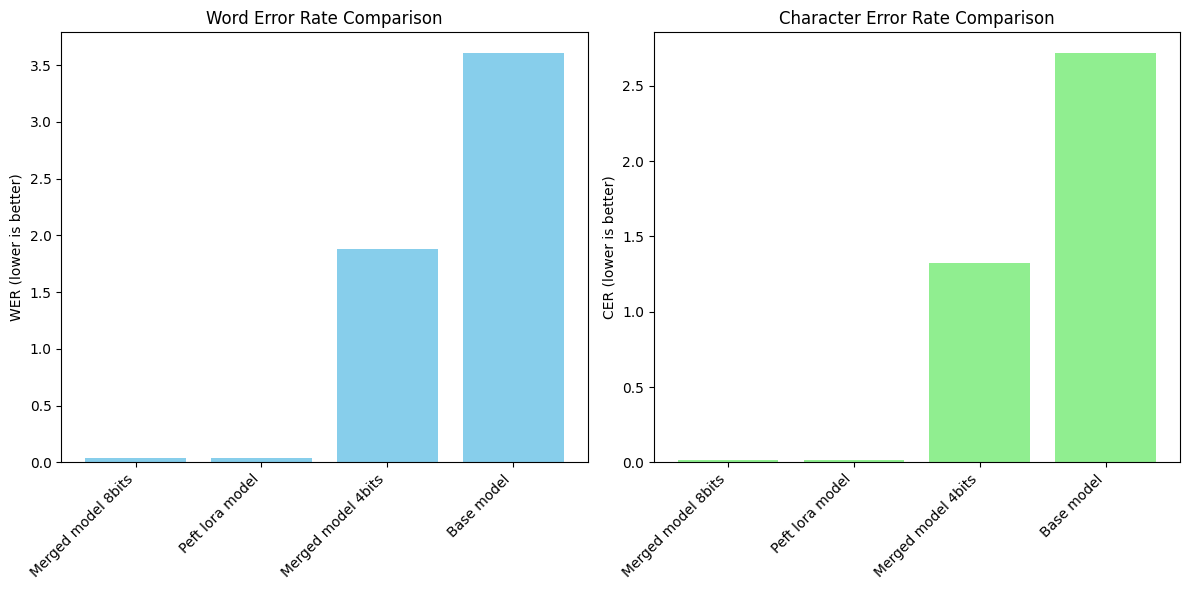


Visualization saved to ocr_model_comparison.png


,Model,WER,CER
3,Merged model 8bits,0.038061,0.013620
1,Peft lora model,0.038568,0.015985
2,Merged model 4bits,1.880497,1.326828
0,Base model,3.607724,2.718979


In [18]:
import matplotlib
#print model comparison
print_model_comparison()